<img src="./logo_UTN.svg" align="right" width="150" />

#### Procesamiento Digital de Señales
# TS9: Filtrado Digital de ECG
#### Eloy Silva

### Configuración e inicio de la simulación. Definición de plantilla.

In [43]:
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,7)

import warnings
warnings.filterwarnings('ignore')

## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla
ripple = 1 #dB. Se realizará un filtrado bidireccional
atenuacion = 20 #dB. Se realizará un filtrado bidireccional

ws1 = 0.1 #Hz
wp1 = 0.5 #Hz
wp2 = 30.0 #Hz
ws2 = 45.0 #Hz

#Plantilla para filtro IIR y FIR con ventana
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

#Plantilla para filtro FIR con cuadrados mínimos
frecs_hp = [frecs[0], frecs[1], frecs[2], frecs[5]]
frecs_lp = [frecs[0], frecs[3], frecs[4], frecs[5]]
gains_ls = np.array([-atenuacion, -atenuacion, -ripple/2, -ripple/2, -atenuacion, -atenuacion])
gains_ls = 10**(gains_ls/20)
gains_hp = [gains_ls[0], gains_ls[1], gains_ls[2], gains_ls[3]]
gains_lp = [gains_ls[2], gains_ls[3], gains_ls[4], gains_ls[5]]

### Diseño de filtro IIR.

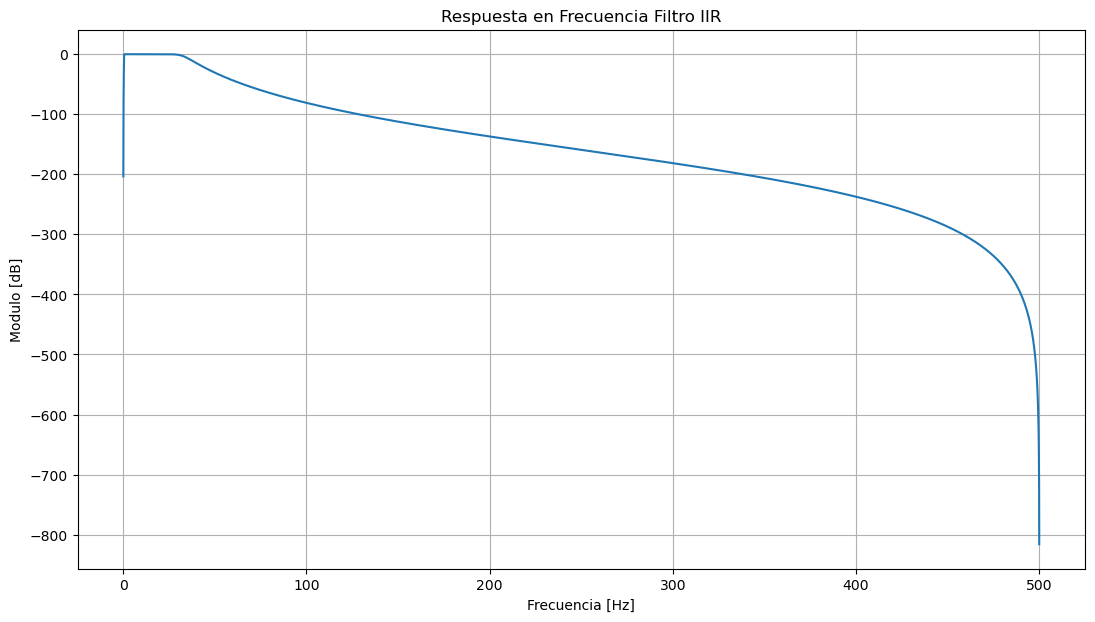

In [44]:
bp_sos_butter = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, atenuacion, ftype='butter', output='sos', fs=fs)

w, h = sig.sosfreqz(bp_sos_butter, worN=20000)
plt.plot((w/np.pi)*nyq_frec, 20*np.log10(np.abs(h)))
plt.title('Respuesta en Frecuencia Filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid()

### Aplicación del filtro de forma bidireccional a regiones de interés con Alta Contaminación para verificar su comportamiento.

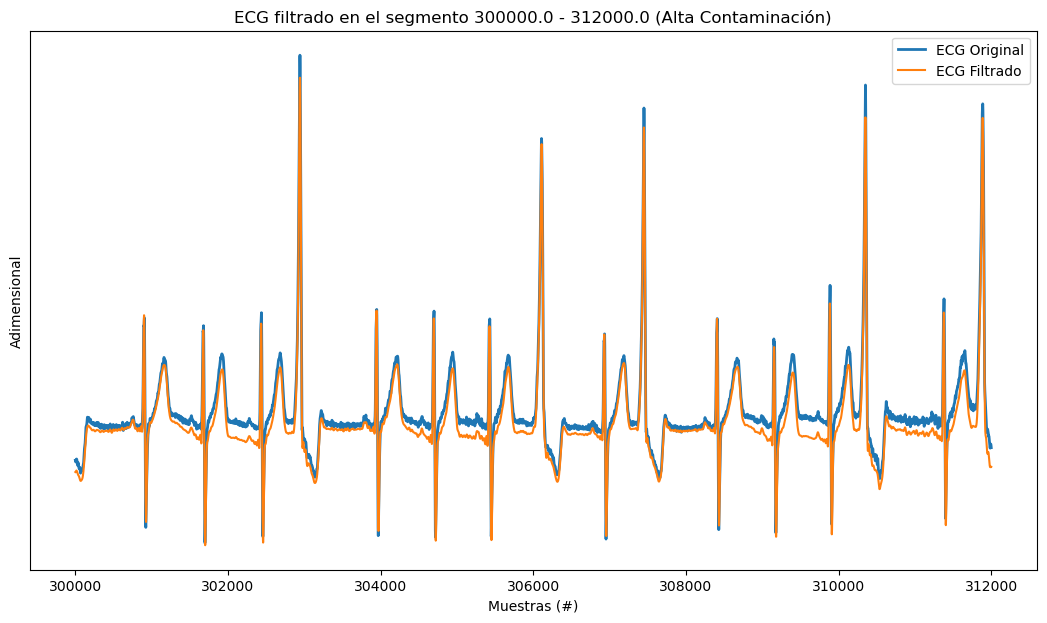

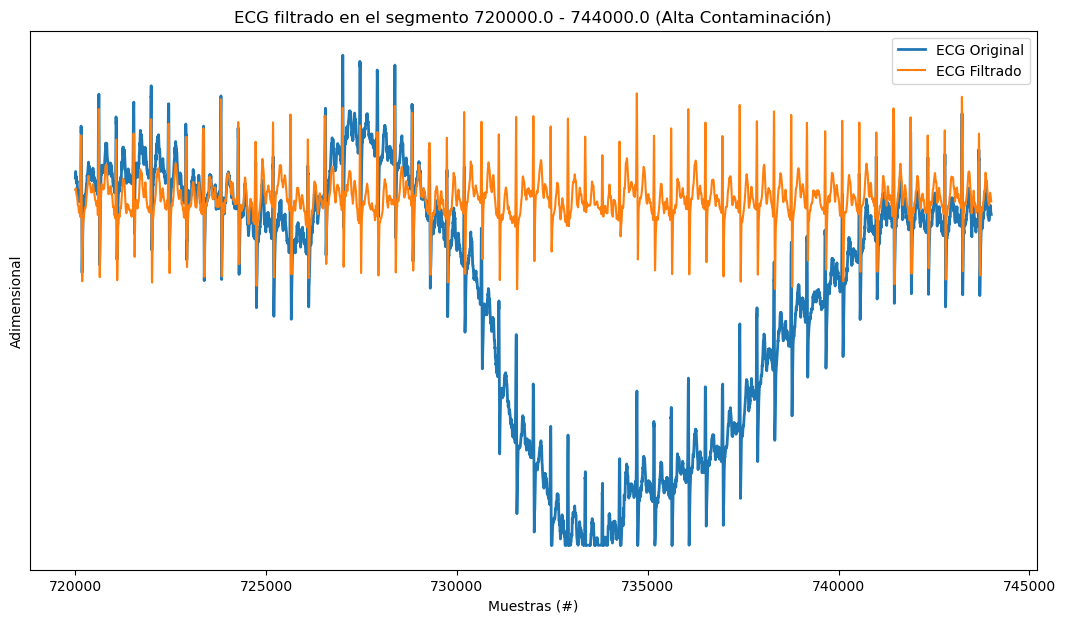

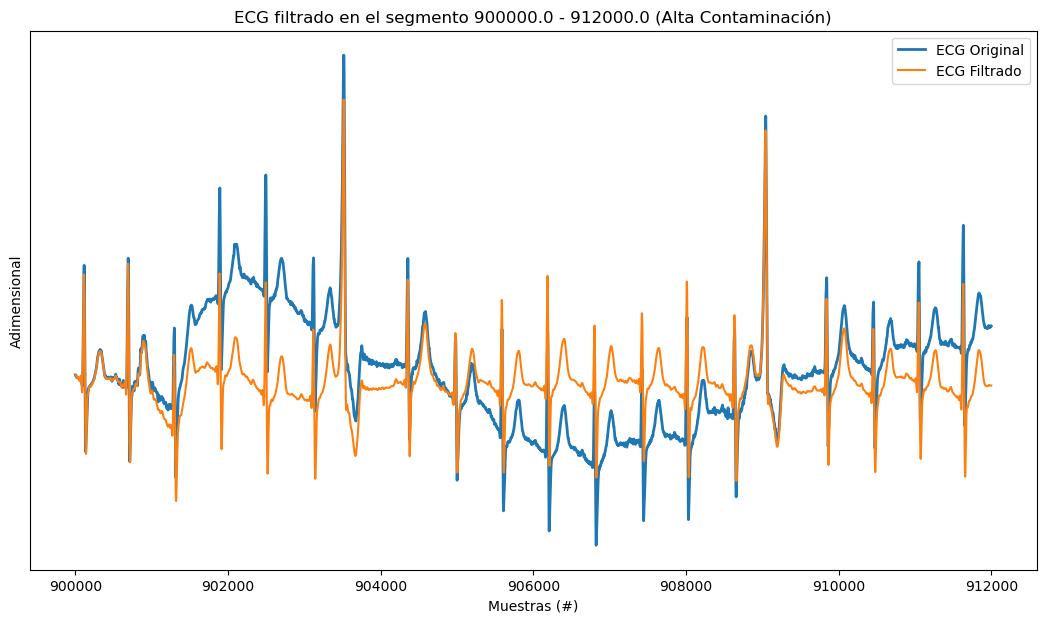

In [45]:
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
demora = 0 #Por el filtrado bidireccional

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG Original', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='ECG Filtrado')
    plt.title('ECG filtrado en el segmento ' + str(ii[0]) + ' - ' + str(ii[1]) + ' (Alta Contaminación)')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

### Aplicación del filtro de forma bidireccional a regiones de interés con Baja Contaminación para verificar su inocuidad.

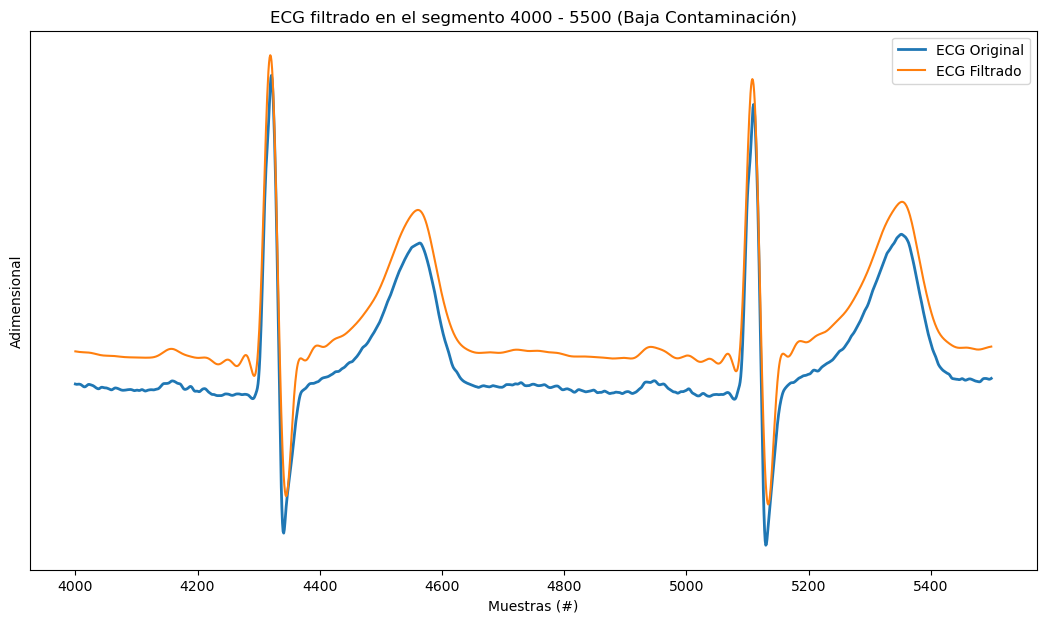

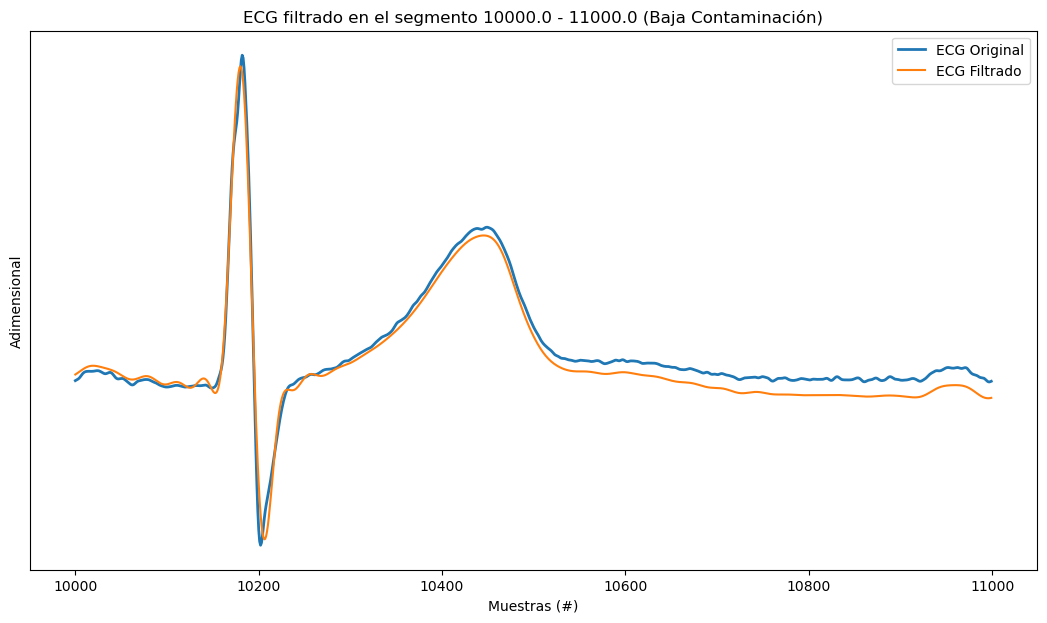

In [46]:
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
demora = 0 #Por el filtrado bidireccional

# Segmentos de interés
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG Original', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='ECG Filtrado')
    plt.title('ECG filtrado en el segmento ' + str(ii[0]) + ' - ' + str(ii[1]) + ' (Baja Contaminación)')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

### Diseño de filtros FIR por ventana y cuadrados mínimos.

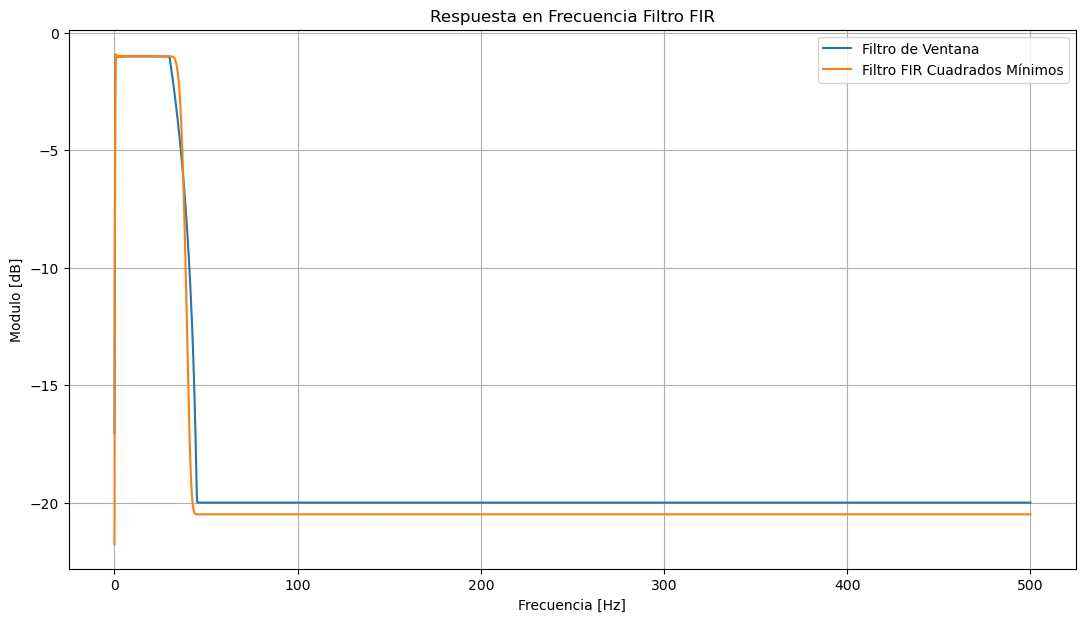

In [47]:
cant_coeficientes = 10001
num_win = sig.firwin2(cant_coeficientes, frecs, gains, window='blackmanharris')
num_ls_hp = sig.firls(cant_coeficientes//2+1, frecs_hp, gains_hp)   #Orden más alto para poder cumplir con la atenuación en baja frecuencia
num_ls_lp = sig.firls(cant_coeficientes//20+1, frecs_lp, gains_lp)  #Menor orden para evitar los overshoots en la banda de transisión
den = 1.0

w, h = sig.freqz(num_win, worN=20000)
w_hp, h_hp = sig.freqz(num_ls_hp, worN=20000)
w_lp, h_lp = sig.freqz(num_ls_lp, worN=20000)
h_ls = h_hp*h_lp

plt.figure()
plt.plot((w/np.pi)*nyq_frec, 20*np.log10(np.abs(h)), label="Filtro de Ventana")
plt.plot((w_hp/np.pi)*nyq_frec, 20*np.log10(np.abs(h_ls)), label="Filtro FIR Cuadrados Mínimos")
plt.title('Respuesta en Frecuencia Filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.legend()
plt.grid()

### Aplicación de los filtros de forma bidireccional a regiones de interés con Alta Contaminación para verificar su comportamiento.

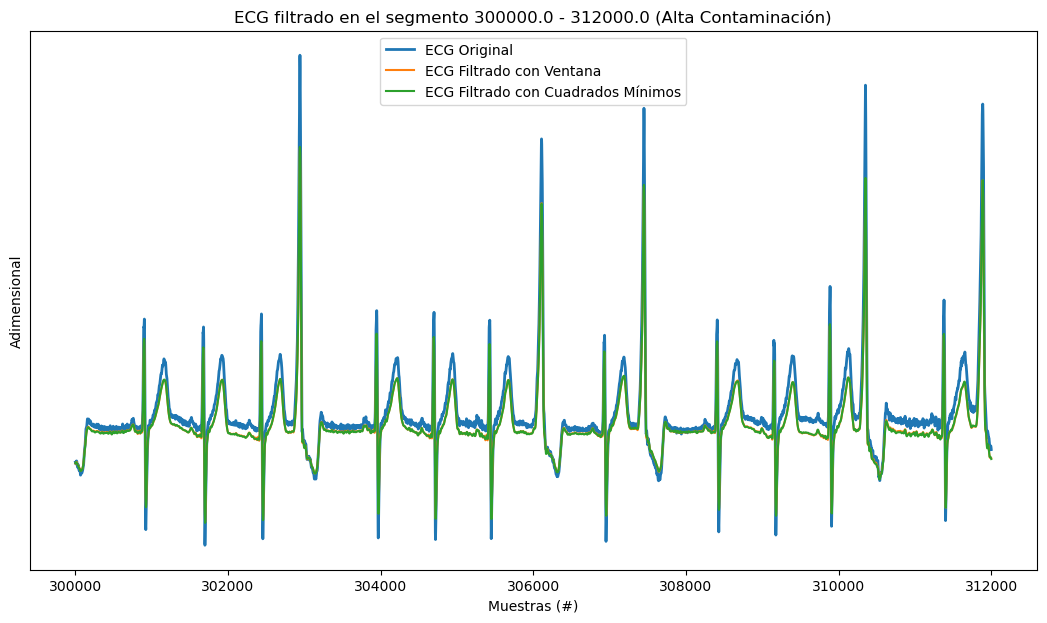

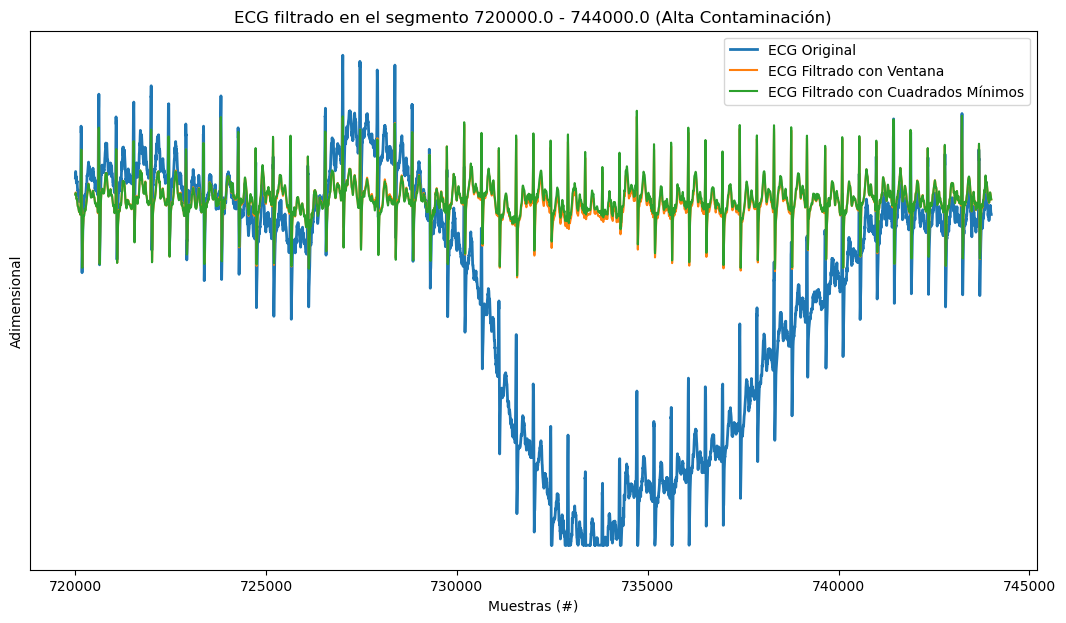

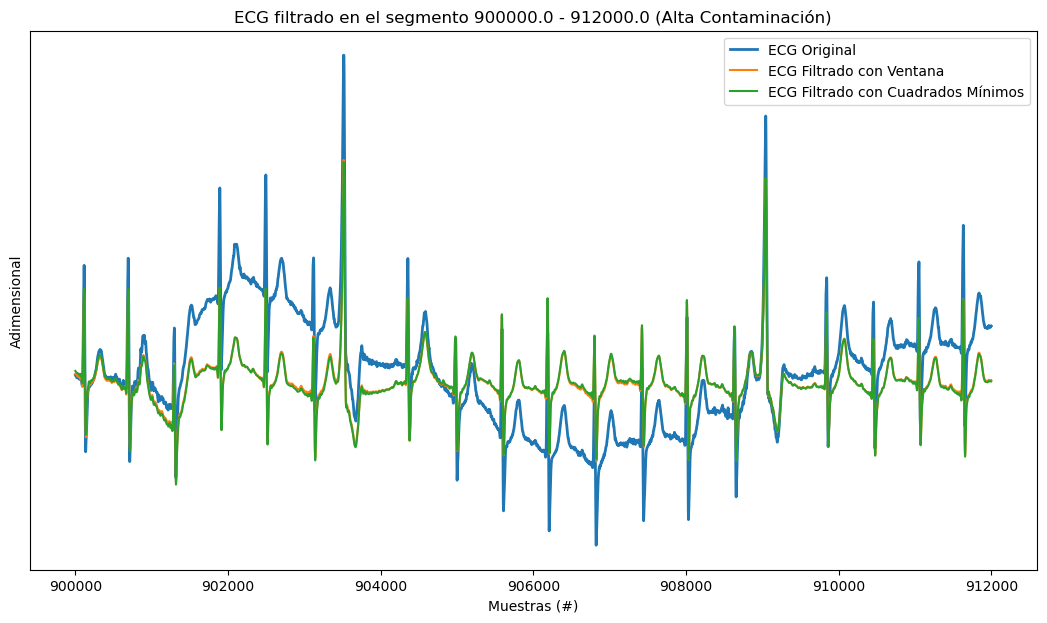

In [48]:
ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)
ECG_f_ls = sig.filtfilt(num_ls_hp, den, ecg_one_lead)
ECG_f_ls = sig.filtfilt(num_ls_lp, den, ECG_f_ls)      #Se aplica el filtro FIR por cuadrados mínimos en cascada
demora = 0 #Por el filtrado bidireccional

# Segmentos de interés contaminación
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG Original', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='ECG Filtrado con Ventana')
    plt.plot(zoom_region, ECG_f_ls[zoom_region + demora], label='ECG Filtrado con Cuadrados Mínimos')
    plt.title('ECG filtrado en el segmento ' + str(ii[0]) + ' - ' + str(ii[1]) + ' (Alta Contaminación)')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

### Aplicación de los filtros de forma bidireccional a regiones de interés con Baja Contaminación para verificar su inocuidad.

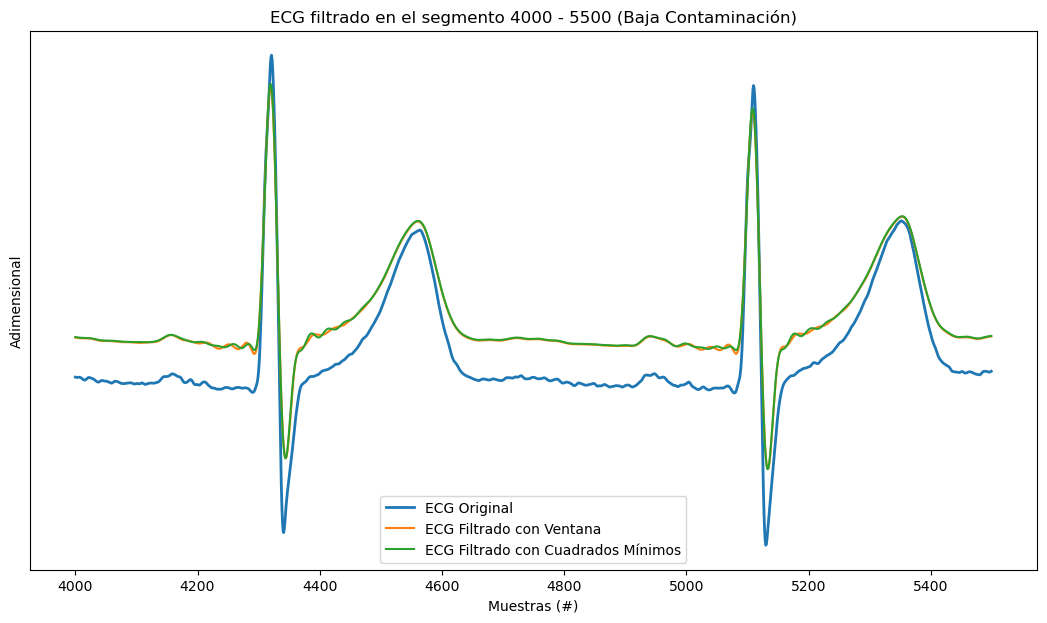

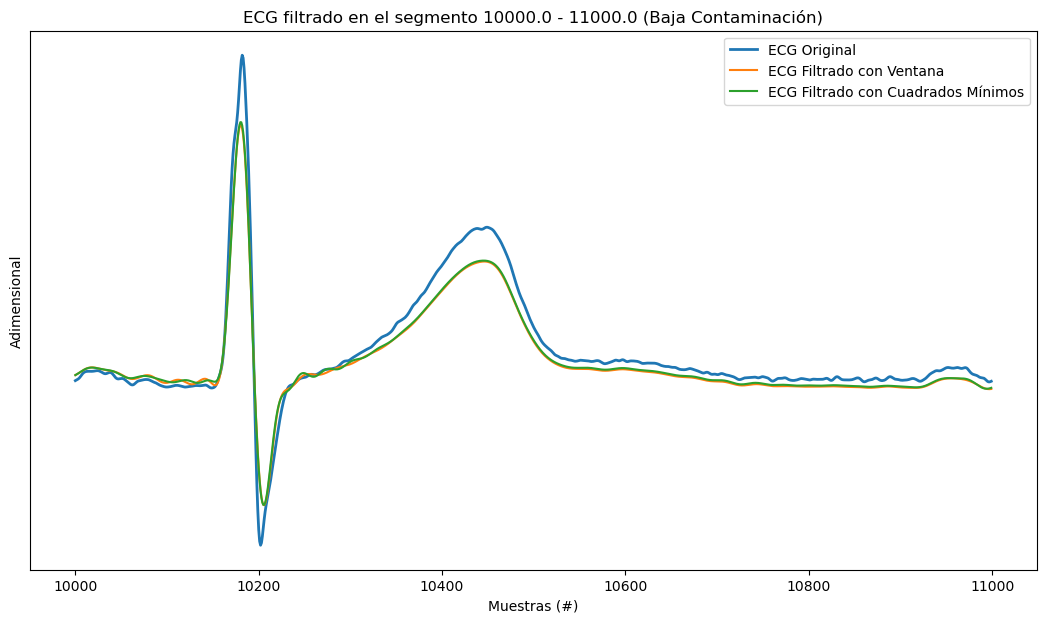

In [49]:
ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)
ECG_f_ls = sig.filtfilt(num_ls_hp, den, ecg_one_lead)
ECG_f_ls = sig.filtfilt(num_ls_lp, den, ECG_f_ls)
demora = 0 #Por el filtrado bidireccional

# Segmentos de interés contaminación
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG Original', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='ECG Filtrado con Ventana')
    plt.plot(zoom_region, ECG_f_ls[zoom_region + demora], label='ECG Filtrado con Cuadrados Mínimos')
    plt.title('ECG filtrado en el segmento ' + str(ii[0]) + ' - ' + str(ii[1]) + ' (Baja Contaminación)')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

### Si bien se aprecia que tanto el filtro IIR como los filtros FIR eliminan las contaminaciones de baja frecuencia, no lo hacen de la manera más eficiente ya que para evitar las distorsiones de fase se tuvo que hacer un filtrado bidireccional.
### El hecho de que los filtros no sean totalmente inocuos en la banda de paso se debe a que su respuesta en frecuencia se extiende en el tiempo por tener que actuar en frecuencias bajas. Es por esto que las señales filtradas en las regiones con baja contaminación presentan variaciones que no existían, que son producto del largo tiempo que demora el filtro en llegar a su valor de establecimiento.
### Se ve que tanto el filtro FIR de ventana como el FIR de cuadrados mínimos se comportan de forma similar para las zonas con y sin contaminación, por eso se ven superpuestos en la mayoría de los gráficos